In [1]:
%pylab inline
import scipy.integrate as integrate
from scipy.optimize import curve_fit

Populating the interactive namespace from numpy and matplotlib


In [2]:
# solve_ivp functions

# returns vector of dx/dt, dAcx/dt and dAx/dt in that order

def derivs(t, y, nu, xs,K,r,atot):
    x0 = y[0]               # position of hub
    N = int(0.5*(len(y)-1))   # of lattice sites
    Ac = y[1:N+1]          # bound complex on lattice
    As = y[-N:]             # unbound complex on lattice
    
    dxdt = integrate.trapz(-(x0-xs)*Ac, x=xs)
    binding = r*exp(-0.5*(x0-xs)**2)*As 
    burnt = nu*Ac
    rebinding = 1/(1+K)*atot-As

    dAcdt = (binding - burnt)
    dAsdt = -binding +rebinding
    
    return array( [dxdt] + list(dAcdt) + list(dAsdt))

In [3]:
# define event as having gone to x = 20.0
def event(t, y):
    x0 = y[0]
        
    return 20.0-x0

event.direction = 0        
event.terminal = True     # stop solver if event satisfied

In [18]:
# use solve_ivp to find solution from t0=0 up to a max tf= 400, but stop if x hits x=20.0

tf = 40.0

a0 = 100.0
nu = 100.0

Ks = logspace(-2,0,3,base = 10)
Ks = ones(1)
K_n = len(Ks)
rs = logspace(2,3,2,base = 10)
#rs = ones(1)*100
r_n = len(rs)

# define domain and lattice
Lmax = 30.0
Lmin = -10.0
dx = 0.1
Nx = int((Lmax-Lmin)/dx) +1
xAs = linspace(Lmin, Lmax, Nx)

print(Ks,rs)

[1.] [ 100. 1000.]


In [19]:

#I.C.

vs = []  # record final speed and burn rate
burnt = []
A = []
for K in Ks:
    
    A0x = zeros(Nx)
    A0x[xAs > 0.0] = a0
    # A0x = a0*ones(Nx) + 0.1*a0*2.0*(0.5-random.random(Nx))

    # iterate over params
    vtmp = []
    btmp = []
    Atmp = []
    for r in rs:
        print(K, r)

        x0 = 0.0
        Ax = 1.0*A0x
        Acx = zeros(Nx)

        # initial conditions for all the equations, y0
        y0 = array([x0] + list(Acx) + list(Ax))

        sol = integrate.solve_ivp(lambda t, y: derivs(t, y, nu, xAs,K,r,a0), (0., tf), y0, method='BDF')

        speed = derivs(sol.t[-1], sol.y[:,-1], nu, xAs,K,r,a0)[0]  #dx/dt
        vtmp.append(speed)
        
        Acxf = sol.y[1:1+Nx,-1]  # final amount of complex
        btot = integrate.trapz(nu*Acxf, x=xAs)    # total rate of burnt at final time 
        btmp.append(btot)
        Atmp.append(sol.y[1:])
        
    vs.append(vtmp)
    burnt.append(btmp)
    A.append(Atmp)
vs = array(vs)
burnt = array(burnt)

1.0 100.0
1.0 1000.0


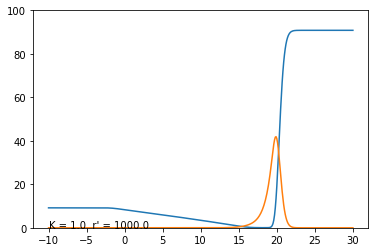

In [ ]:
from IPython import display
for i in range(K_n):
    for j in range(r_n):
        Atmp = A[i][j]
        for t in range(len(Atmp.T)):
            Actmp = Atmp[:Nx][:,t]
            Astmp = Atmp[Nx:][:,t]
            if t % 1 == 0:
                display.clear_output(wait=True)
                plot(xAs,Astmp)
                plot(xAs,Actmp)
                ylim(0,100)
                text(-10,0,"K = " +str(Ks[i])+"  r' = "+str(rs[j]))
                display.display(gcf())
                cla()